# QooQit user journey tutorial

1. Embedders
2. Creating a QuantumProgram
3. Compiling to a device
4. Executing a QuantumProgram

GitHub: https://github.com/pasqal-io/qoolqit

Docs: https://pasqal-io.github.io/qoolqit or https://docs.pasqal.com/qoolqit

## 1. Embedders
Anything that help us to map an abstract problem into something that can be implemented in Pasqal's hardware

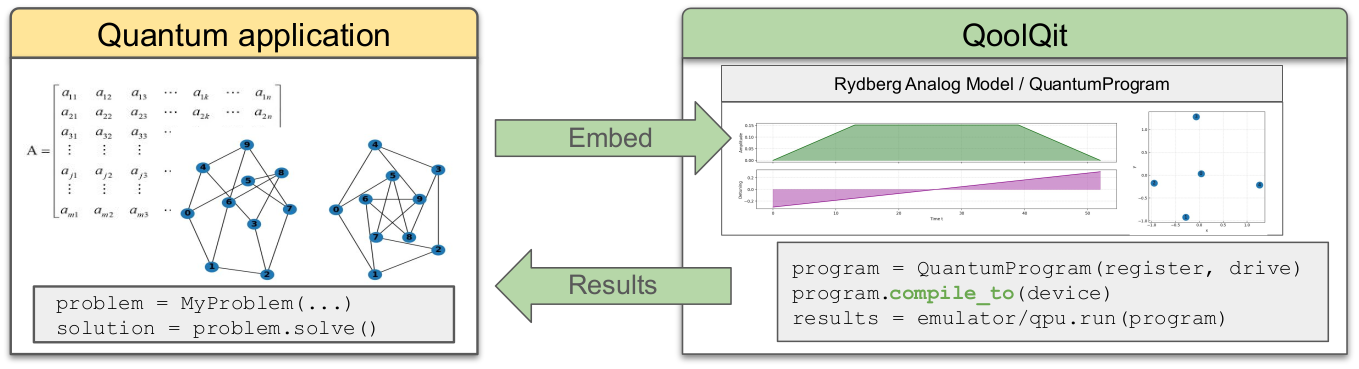

Two available **graph** embedders:
- graph to graph embedder
- matrix to graph embedder

More to come in collaboration with application developers.

Info at https://pasqal-io.github.io/qoolqit/latest/contents/available_embedders/

### a. **Graph->Graph:** SpringLayout Embedder

Embed a generic graph into one with well-defined coordinates positions.

In [16]:
from qoolqit import SpringLayoutEmbedder

sl_embedder = SpringLayoutEmbedder()
print(sl_embedder)

SpringLayoutEmbedder:
| Algorithm: spring_layout_embedding
| Config: SpringLayoutConfig(k=None, iterations=50, threshold=0.0001, seed=None)


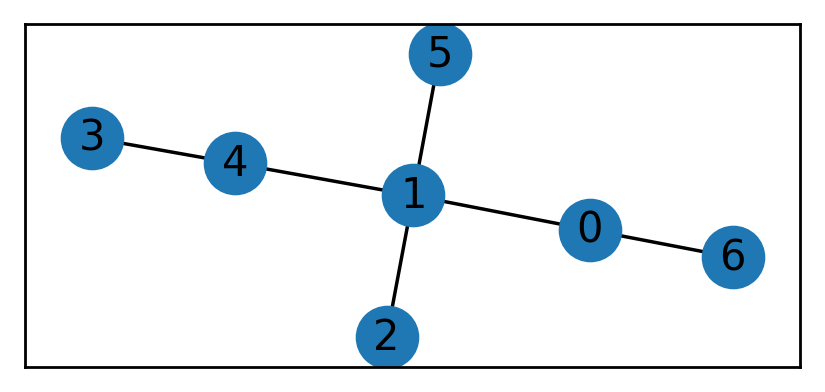

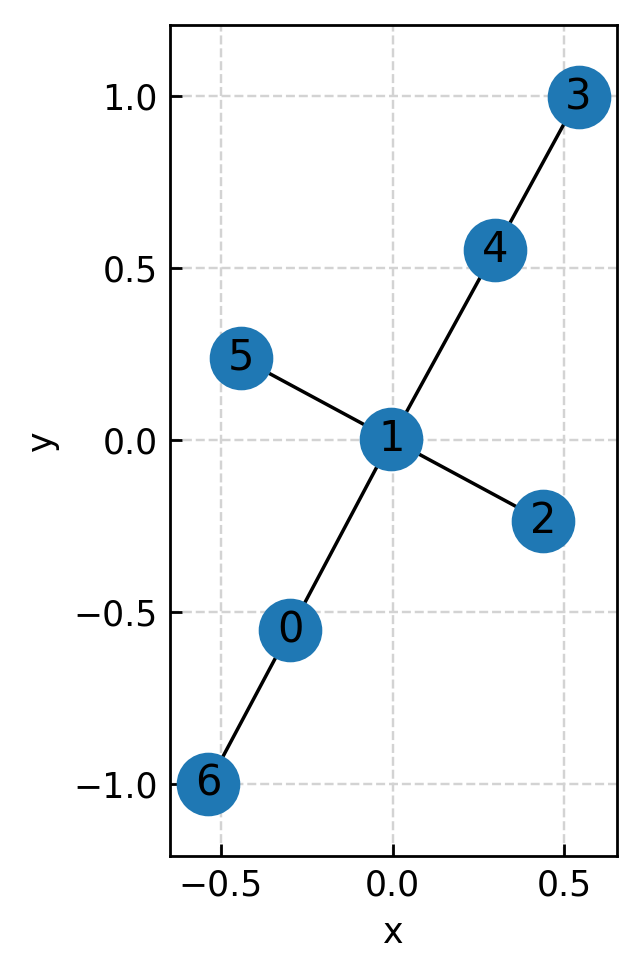

In [17]:
from qoolqit import DataGraph

# start with a graph with no coordinates
graph_1 = DataGraph.random_er(n = 7, p = 0.3, seed = 3)

# embed with spring-layout, assigning coordinates
embedded_graph_1 = sl_embedder.embed(graph_1)

graph_1.draw()
embedded_graph_1.draw()

### b. **Matrix->Graph:** Interaction embedder
Matrix to graph embedders try to embed the off-diagonal elements of a matrix (representing an instance of a QUBO problem for example), into interactions between qubits in the Rydberg Analog Model.

In [18]:
import numpy as np

Q = np.array([
        [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
        [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
        [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
        [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
        [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
])
Q = Q/Q.max()

InteractionEmbedder:
| Algorithm: interaction_embedding
| Config: InteractionEmbeddingConfig(method='Nelder-Mead', maxiter=200000, tol=1e-08)


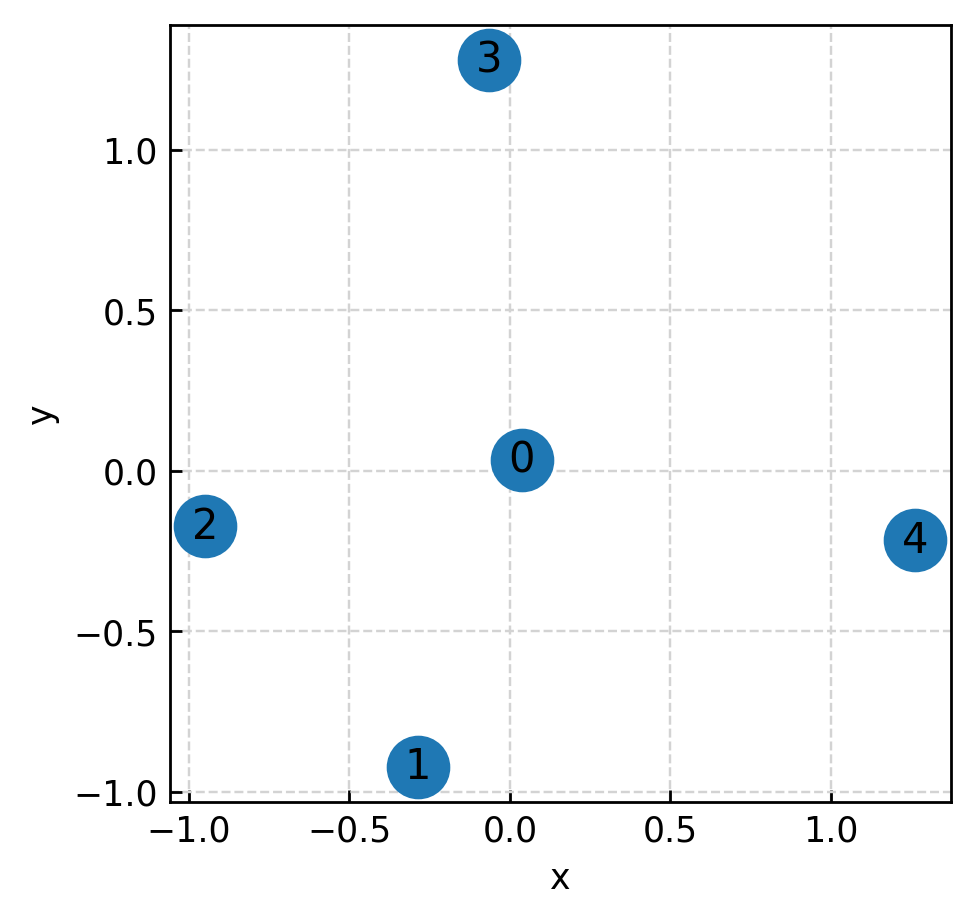

In [19]:
from qoolqit import InteractionEmbedder

embedder = InteractionEmbedder()
print(embedder)

embedded_graph = embedder.embed(Q)
embedded_graph.draw()

# 2. Creating a QuantumProgram

After the embedding stage, creating a QuantumProgram requires the user to specify a register and a drive, to completely specify the Rydberg Analog Model.

Here we target a specific application. Let's solve the QUBO instance defined above.

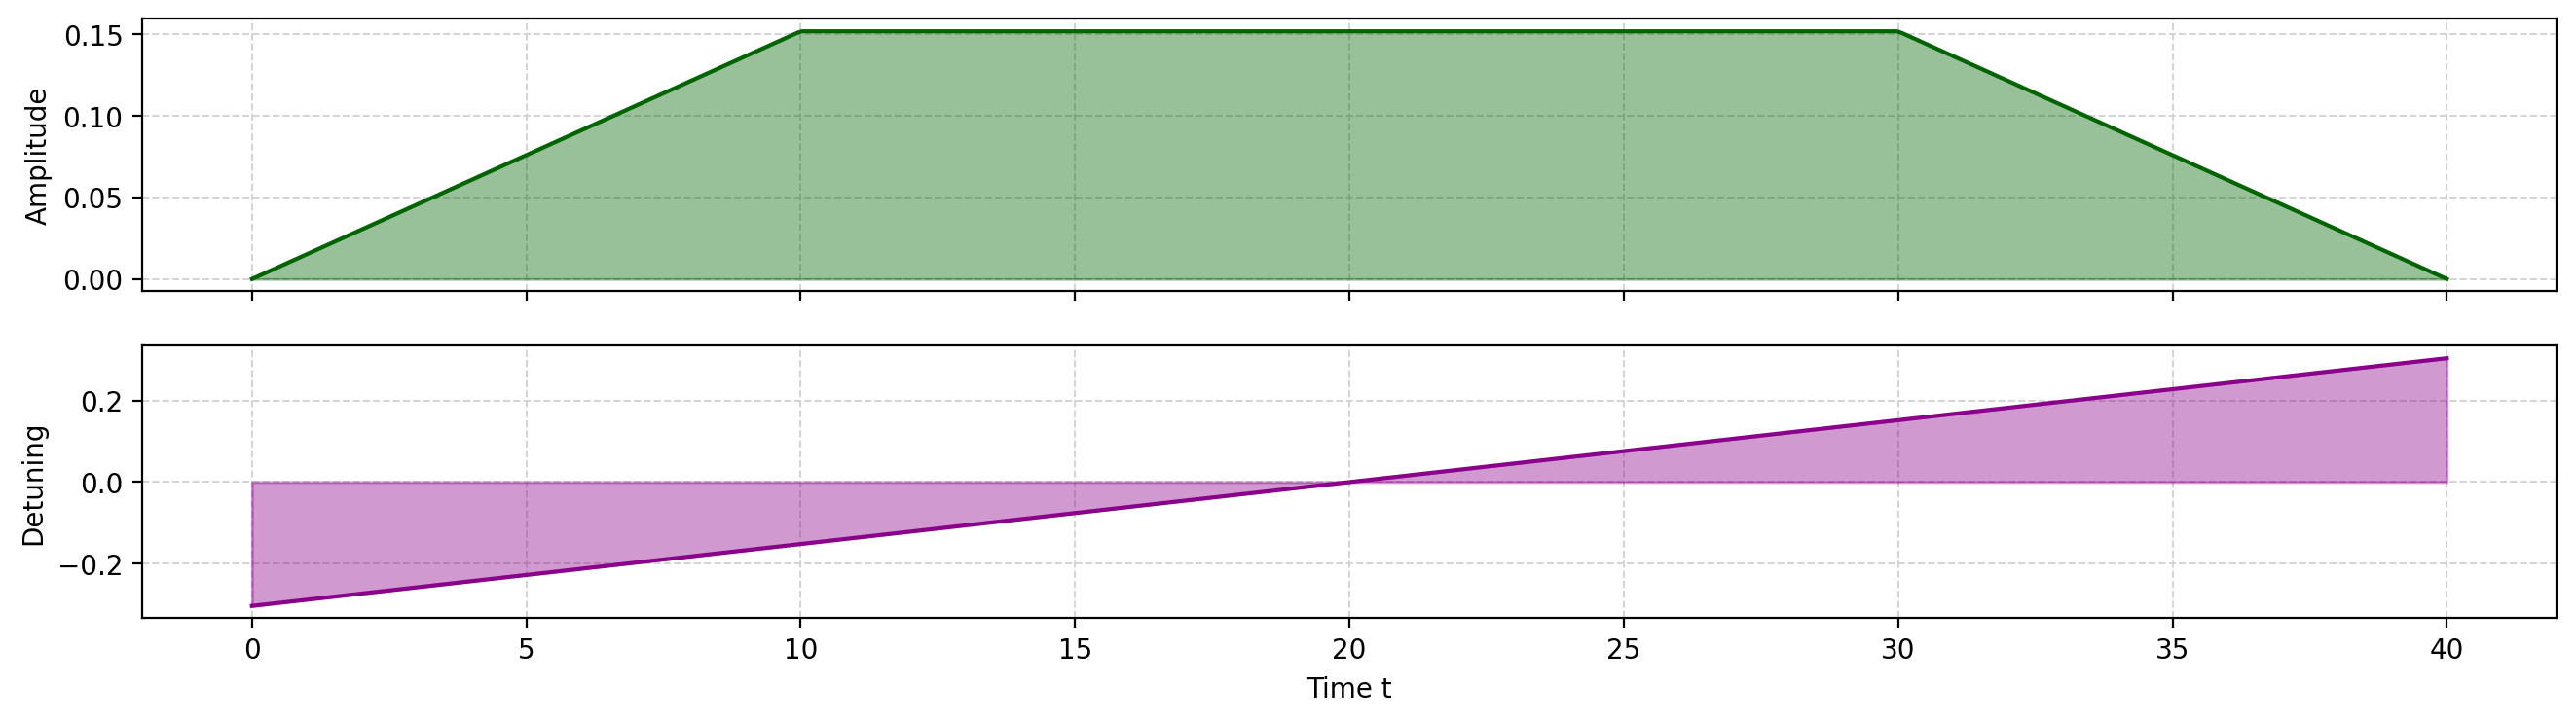

In [20]:
from qoolqit import Drive, PiecewiseLinear, QuantumProgram, Ramp, Register

# Create the register
register = Register.from_graph(embedded_graph)

# Defining the drive
omega = np.median(Q[Q > 0].flatten())
delta_i = -2.0 * omega
delta_f = 2.0 * omega
T = 40.0

amplitude = PiecewiseLinear([T/4, T/2, T/4], [0.0, omega, omega, 0.0])
detuning = Ramp(T, delta_i, delta_f)
drive = Drive(amplitude = amplitude, detuning = detuning)

# Writing the quantum program
program = QuantumProgram(register, drive)
program.draw()

# 3. Compiling to a device
The `QuantumProgram` is hardware-agnostic so far. At this stage the user need to:
- Pick a device. Could be a real QPU or a digital-twin. 
- Pick a compilation strategy. Here, we show the basic one and MAX_DURATION.

Importantly, a program **must** be compiled before being executed (see later in this notebook).

In [21]:
from qoolqit import AnalogDevice

device = AnalogDevice() # pick a device
program.compile_to(device=device) # basic compilation

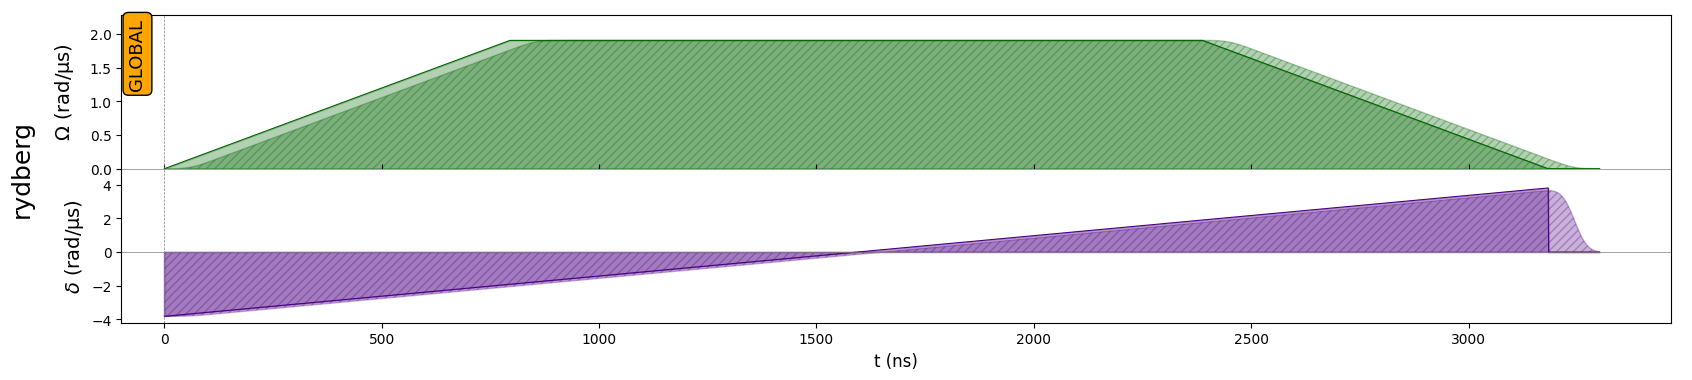

In [22]:
# view the compiled Pulser sequence
program.compiled_sequence.draw()

The max duration strategy, compile the same quantum program, but prioritize making the sequence longer, lowering the maximum amplitude and increasing interatomic distance between atoms. 

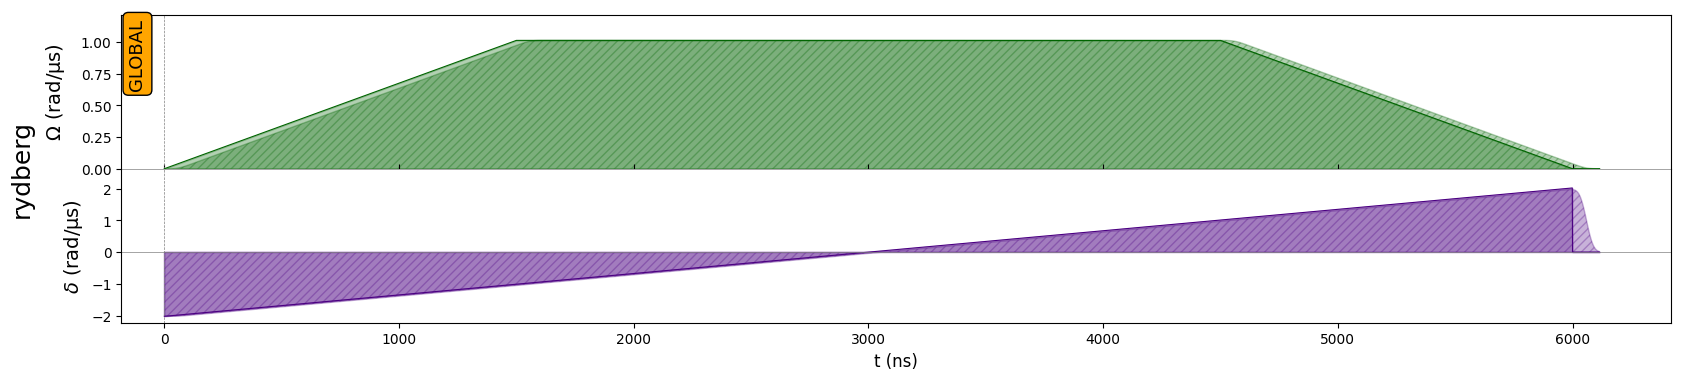

In [23]:
from qoolqit.execution import CompilerProfile

program.compile_to(device=device, profile=CompilerProfile.MAX_DURATION)
program.compiled_sequence.draw()

## 4. Execution
Execution has to cover use-cases from **beginner** to **advanced**.

- Local/remote emulators, QPU
- More info at https://pasqal-io.github.io/qoolqit/latest/contents/execution/

The easiest way to run a program is to use an emulator.
- Same Results object as in Pulser
- TODO: convenient post-processing methods

In [24]:
from qoolqit.execution import LocalEmulator

emulator = LocalEmulator()
results = emulator.run(program)[0]
# final bitstrings from results
counter = results.final_bitstrings
print(counter)

Counter({'01011': 39, '00111': 37, '00011': 10, '00110': 4, '10000': 3, '01001': 3, '01010': 2, '00101': 1, '10011': 1})


## Show results

This QUBO instance is small so we can also easily check for its classical solutions.

In [25]:
# Classical solution
bitstrings = np.array([np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))])
bitstring_lists = np.array([np.array(list(b), dtype=int) for b in bitstrings])
costs = np.array([z.T @ Q @ z for z in bitstring_lists])
idx_sort = np.argsort(costs).tolist()

sorted_costs = costs[idx_sort]
sorted_bitstrings = bitstrings[idx_sort]

print("Two best solutions: ", sorted_bitstrings[:2])
print("Respective costs: ", sorted_costs[:2])

# We save the two best solutions for plotting
marked_bitstrings = sorted_bitstrings[:2]

Two best solutions:  ['01011' '00111']
Respective costs:  [-1.31978679 -1.31978679]


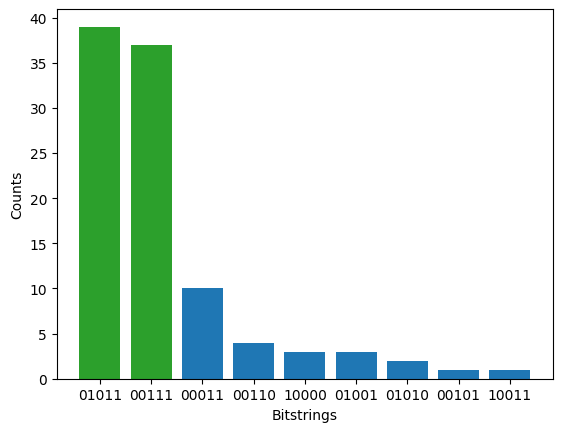

In [26]:
import matplotlib.pyplot as plt


def plot_distribution(counter, solutions, bins=10):
    counter = dict(counter.most_common(bins))
    color = ["tab:green" if key in solutions.tolist() else "tab:blue" for key in counter]
    fig, ax = plt.subplots()
    ax.set_xlabel("Bitstrings")
    ax.set_ylabel("Counts")
    ax.bar(range(len(counter)), counter.values(), color=color, tick_label=counter.keys())
    return fig

fig = plot_distribution(counter, marked_bitstrings)

As we can see, the bitstrings we had marked as the optimal solutions of this QUBO problem were the ones sampled with the highest probability, meaning the the QUBO problem was successfully solved with the quantum program we defined.

### a. Configure your emulator [Advanced]
A more complex use-case is, for example, configuring a remote backend.
More info at https://pasqal-io.github.io/qoolqit/latest/contents/execution/

Remote execution requires a connection object to connect to Pasqal Cloud services:

In [27]:
import os

from pulser_pasqal import PasqalCloud

# store credentials as env variables
connection = PasqalCloud(
        username=os.getenv("PCP_USER"), 
        password=os.getenv("PCP_PASSWORD"), 
        project_id=os.getenv("PCP_PROJECT_ID")
        )

Advanced users might want to fully configure an emulator backend to exploit all its possibilities:
- defining observables to measure
- emulate real hardware-modulation effects

In [28]:
from qoolqit.execution import EmulationConfig, EmuMPSBackend, Occupation, RemoteEmulator

observables = (Occupation(),)
emulation_config = EmulationConfig(observables=observables, with_modulation=True)

emulator = RemoteEmulator(
    backend_type=EmuMPSBackend,
    connection=connection,
    emulation_config=emulation_config,
    runs=1000
    )

In [29]:
# results = emulator.run(program)